In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import random

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
exc = 0.4
inh = 0.322

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
dur = 500.
t_pen = 0.7
int_t_pen = int((1.-t_pen)*dur/aln.params.dt)

In [5]:
file_ = '3_E.pickle'
folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = '3'

/high_osc


In [6]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-10
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

p_var = [0]
c_var = [1]
wp = 1. / (dur - t_pen * dur)

if case in ['1', '2']:    # osc to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
else:
    factor_ws = 0.
    factor_we = 1.
    
maxC = [5., -5., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [7]:
bestControl_ = None

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]

file found


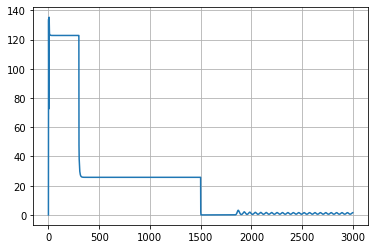

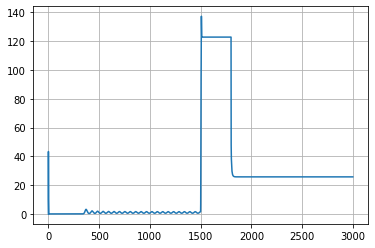

25.73160170281955
[1.17898505 0.62173334 0.52288618 0.89937247 1.46940135 1.37573782
 0.76735634 0.50087305 0.72655858 1.30945585 1.51115031 0.95992528
 0.53165845 0.59802359 1.10501279]


In [8]:
# get initial parameters and target states
data.set_parameters(aln)

aln.params.ext_exc_current = exc * 5.
aln.params.ext_inh_current = inh * 5.

aln.params.duration = 3000.

control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = max_I[0])

aln.run(control=control0)
plt.plot(aln.t, aln.rates_exc[0,:])
plt.show()

target_rates = np.zeros((2, int_t_pen))
target_rates[0,:] = aln.rates_exc[0,-int_t_pen:] 
target_rates[1,:] = aln.rates_inh[0,-int_t_pen:]

control0 = functions.step_control(aln, maxI_ = max_I[1])
aln.run(control=control0)
plt.plot(aln.t, aln.rates_exc[0,:])
plt.show()

init_state_vars = np.zeros(( len(state_vars) ))
for j in range(len(state_vars)):
    if aln.state[state_vars[j]].size == 1:
        init_state_vars[j] = aln.state[state_vars[j]][0]
    else:
        init_state_vars[j] = aln.state[state_vars[j]][0,-1]

initVars = init_state_vars
target = [target_rates[0,:], target_rates[1,:]]

print(initVars[0])
print(target[0][::100])

In [9]:
# get uncontrolled cost
    
aln.params.duration = dur

target_ = aln.getZeroTarget()
target_[:,0,-int_t_pen:] = target[0]
target_[:,1,-int_t_pen:] = target[1]

cost.setParams(wp, 0.0, 0.0)

setinit(initVars, aln)
control0 = aln.getZeroControl()

cgv = None
max_it = 0

bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
    control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
    startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
    prec_variables_ = p_var, transition_time_ = t_pen)

cost_uncontrolled = cost_init_[0]

set cost params:  0.006666666666666667 0.0 0.0
interpolate adjoint :  True True True
initial cost =  307.22769784192036
RUN  0 , total integrated cost =  307.22769784192036
Gradient descend method:  None
RUN  0 , total integrated cost =  307.22769784192036
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


set cost params:  0.006666666666666667 0.0 10.0
interpolate adjoint :  True True True
initial cost =  155.14948496973525
RUN  0 , total integrated cost =  155.14948496973525
Gradient descend method:  None
RUN  1 , total integrated cost =  155.14948496973525
Control only changes marginally.
RUN  1 , total integrated cost =  155.14948496973525
Improved over  1  iterations in  22.377448874001857  seconds by  0.0  percent.


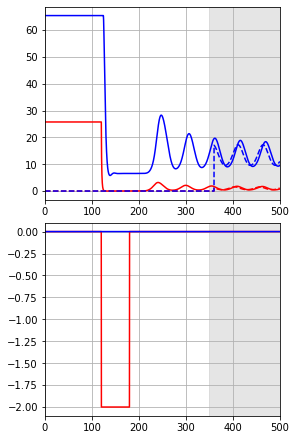

uncontrolled cost :  307.22769784192036
cost splitting :  34.52266821567623 [15.49193338  0.        ]


In [10]:
cgv = None
j = 0

aln.params.duration = dur
setinit(initVars, aln)

target_ = aln.getZeroTarget()
target_[:,0,-int_t_pen:] = target[0]
target_[:,1,-int_t_pen:] = target[1]

control0 = aln.getZeroControl()
cost.setParams(wp, 0., 10.)
max_it = int(10)

control0[0,0,1200:1800] = -2.

bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
    control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
    startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
    prec_variables_ = p_var, transition_time_ = t_pen)

if True:
    plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,-int_t_pen:] = target[0]
    target_[:,1,-int_t_pen:] = target[1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,6) )
    ax[1].plot(plot_time_array, bestControl_[0,0,n_pre-1:-n_post+1], color = 'red')
    ax[0].plot(plot_time_array, bestState_[0,0,n_pre-1:-n_post+1], color= 'red')
    ax[1].plot(plot_time_array, bestControl_[0,1,n_pre-1:-n_post+1], color = 'blue')
    ax[0].plot(plot_time_array, bestState_[0,1,n_pre-1:-n_post+1], color= 'blue')
    ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
    ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

    for k in range(2):
        ax[k].set_xlim(0.,dur)
        ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()

print('uncontrolled cost : ', cost_uncontrolled)
print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])    

set cost params:  0.006666666666666667 0.0 17.09276539442651
interpolate adjoint :  True True True
initial cost =  265.0301339744164
RUN  0 , total integrated cost =  265.0301339744164
Gradient descend method:  None
RUN  1 , total integrated cost =  47.08067802326953
RUN  2 , total integrated cost =  46.99526934926146
RUN  3 , total integrated cost =  46.987624911303904
RUN  4 , total integrated cost =  43.57961986127257
RUN  5 , total integrated cost =  43.178113136028664
RUN  6 , total integrated cost =  43.17373819771643
RUN  7 , total integrated cost =  43.16796302643157
RUN  8 , total integrated cost =  43.16365249878945
RUN  9 , total integrated cost =  43.15536443048567
RUN  10 , total integrated cost =  43.14867668759854
RUN  11 , total integrated cost =  43.142228903792756
RUN  12 , total integrated cost =  43.13658390109427
RUN  13 , total integrated cost =  43.12617395956648
RUN  14 , total integrated cost =  43.121233704718975
RUN  15 , total integrated cost =  43.116686840

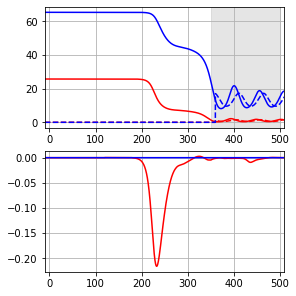

In [11]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-6
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,-int_t_pen:] = target[0]
    target_[:,1,-int_t_pen:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,-int_t_pen:] = target[0]
        target_[:,1,-int_t_pen:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

set cost params:  0.006666666666666667 0.0 170.44795666992033
interpolate adjoint :  True True True
initial cost =  175.25605153437454
RUN  0 , total integrated cost =  175.25605153437454
Gradient descend method:  None
RUN  1 , total integrated cost =  175.25104103398687
RUN  2 , total integrated cost =  175.25074499629773
RUN  3 , total integrated cost =  175.2504386975258
RUN  4 , total integrated cost =  175.25021988028593
RUN  5 , total integrated cost =  175.2499696207683
RUN  6 , total integrated cost =  175.24981282093532
RUN  7 , total integrated cost =  175.24962356023397
RUN  8 , total integrated cost =  175.24947766508103
RUN  9 , total integrated cost =  175.24929630792192
RUN  10 , total integrated cost =  175.249166543144
RUN  11 , total integrated cost =  175.2490016787823
RUN  12 , total integrated cost =  175.24887280277773
RUN  13 , total integrated cost =  175.24870351747575
RUN  14 , total integrated cost =  175.24856360463045
RUN  15 , total integrated cost =  175.

RUN  6 , total integrated cost =  243.50131516599507
RUN  7 , total integrated cost =  243.5012116828139
RUN  8 , total integrated cost =  243.50112901826606
RUN  9 , total integrated cost =  243.49973047743168
RUN  10 , total integrated cost =  243.49842658678466
RUN  11 , total integrated cost =  243.49717173290142
RUN  12 , total integrated cost =  243.49576079648844
RUN  13 , total integrated cost =  243.49569634690758
RUN  14 , total integrated cost =  243.49560608674204
RUN  15 , total integrated cost =  243.4955638964618
RUN  16 , total integrated cost =  243.4954927219331
RUN  17 , total integrated cost =  243.49543043449526
RUN  18 , total integrated cost =  243.49520109926752
RUN  19 , total integrated cost =  243.49503851070895
RUN  20 , total integrated cost =  243.49475641030554
RUN  30 , total integrated cost =  243.33126455088023
RUN  30 , total integrated cost =  243.33126455088023
Improved over  30  iterations in  9.033956448023673  seconds by  0.07107897574890387  per

RUN  2 , total integrated cost =  287.9373725384756
RUN  3 , total integrated cost =  287.9373725384756
Control only changes marginally.
RUN  3 , total integrated cost =  287.9373725384756
Improved over  3  iterations in  1.0331063740013633  seconds by  8.918859734308171e-06  percent.
cost splitting :  6.444375922544896 [1.02316196e+00 1.10639881e-08]
set cost params:  0.006666666666666667 0.0 257.1500636372954
interpolate adjoint :  True True True
initial cost =  263.149129534506
RUN  0 , total integrated cost =  263.149129534506
Gradient descend method:  None
RUN  1 , total integrated cost =  263.149035622911
RUN  2 , total integrated cost =  263.149035622911
Control only changes marginally.
RUN  2 , total integrated cost =  263.149035622911
Improved over  2  iterations in  0.742454633989837  seconds by  3.5687594774458375e-05  percent.
cost splitting :  6.106458399747486 [1.02317036e+00 1.10639881e-08]


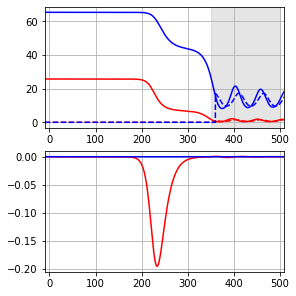

In [12]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-8
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,-int_t_pen:] = target[0]
    target_[:,1,-int_t_pen:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,-int_t_pen:] = target[0]
        target_[:,1,-int_t_pen:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

set cost params:  0.006666666666666667 0.0 9.949818326736628
interpolate adjoint :  True True True
initial cost =  10.221069026996034
RUN  0 , total integrated cost =  10.221069026996034
Gradient descend method:  None
RUN  1 , total integrated cost =  10.207582457413114
RUN  2 , total integrated cost =  10.207573474908822
RUN  3 , total integrated cost =  10.207573348832241
RUN  4 , total integrated cost =  10.207573022042276
RUN  5 , total integrated cost =  10.207572922254867
RUN  6 , total integrated cost =  10.207569238041684
RUN  7 , total integrated cost =  10.207565790018771
RUN  8 , total integrated cost =  10.207565700958888
RUN  9 , total integrated cost =  10.20756537366736
RUN  10 , total integrated cost =  10.207565278842395
RUN  11 , total integrated cost =  10.207562357227236
RUN  12 , total integrated cost =  10.20755931494764
RUN  13 , total integrated cost =  10.207559227726748
RUN  14 , total integrated cost =  10.207558899858265
RUN  15 , total integrated cost =  10

RUN  7 , total integrated cost =  0.4194318714541709
RUN  8 , total integrated cost =  0.41942855445476374
RUN  9 , total integrated cost =  0.4194259707763891
RUN  10 , total integrated cost =  0.4194227054973332
RUN  11 , total integrated cost =  0.419420208150904
RUN  12 , total integrated cost =  0.4194169466762851
RUN  13 , total integrated cost =  0.4194143810174964
RUN  14 , total integrated cost =  0.41941105208539264
RUN  15 , total integrated cost =  0.41940849333194186
RUN  16 , total integrated cost =  0.41940516695998536
RUN  17 , total integrated cost =  0.41940280963590293
RUN  18 , total integrated cost =  0.4193994343263552
RUN  19 , total integrated cost =  0.41939701104531524
RUN  20 , total integrated cost =  0.4193936507041938
RUN  30 , total integrated cost =  0.4193650034882049
RUN  30 , total integrated cost =  0.4193650034882049
Improved over  30  iterations in  5.81593753802008  seconds by  0.9556134986540172  percent.
cost splitting :  3.7557732988638057 [1.0

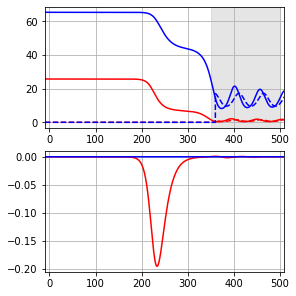

In [13]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-10
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,-int_t_pen:] = target[0]
    target_[:,1,-int_t_pen:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,-int_t_pen:] = target[0]
        target_[:,1,-int_t_pen:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

set cost params:  0.006666666666666667 0.0 27.105944157206046
interpolate adjoint :  True True True
initial cost =  27.764971135526434
RUN  0 , total integrated cost =  27.764971135526434
Gradient descend method:  None
RUN  1 , total integrated cost =  27.762687041911292
RUN  2 , total integrated cost =  27.762684151287264
RUN  3 , total integrated cost =  27.76268358868989
RUN  4 , total integrated cost =  27.762682884335803
RUN  5 , total integrated cost =  27.762681743081632
RUN  6 , total integrated cost =  27.762680640739095
RUN  7 , total integrated cost =  27.76267899972146
RUN  8 , total integrated cost =  27.76267742902986
RUN  9 , total integrated cost =  27.762660191984086
RUN  10 , total integrated cost =  27.762643127415163
RUN  11 , total integrated cost =  27.76264309338735
RUN  12 , total integrated cost =  27.762642991099117
RUN  13 , total integrated cost =  27.762642538213562
RUN  14 , total integrated cost =  27.762642510238635
RUN  15 , total integrated cost =  27.

RUN  20 , total integrated cost =  215.7681516867067
Control only changes marginally.
RUN  27 , total integrated cost =  215.76813755990446
Improved over  27  iterations in  9.974345311988145  seconds by  0.0054347949398732  percent.
cost splitting :  5.422135217057343 [1.02318800e+00 2.20500456e-12]
set cost params:  0.006666666666666667 0.0 244.09339848794505
interpolate adjoint :  True True True
initial cost =  249.7895839248924
RUN  0 , total integrated cost =  249.7895839248924
Gradient descend method:  None
RUN  1 , total integrated cost =  249.7893529596223
RUN  2 , total integrated cost =  249.78935289102898
RUN  3 , total integrated cost =  249.78930760290368
RUN  4 , total integrated cost =  249.78927054793948
RUN  5 , total integrated cost =  249.78927049959302
RUN  6 , total integrated cost =  249.7892704791453
RUN  7 , total integrated cost =  249.78926970221292
RUN  8 , total integrated cost =  249.78926776191022
RUN  9 , total integrated cost =  249.7892675529071
RUN  10

RUN  13 , total integrated cost =  177.99068639201852
RUN  14 , total integrated cost =  177.99067549091987
RUN  15 , total integrated cost =  177.99065771047216
RUN  16 , total integrated cost =  177.99065068075484
RUN  17 , total integrated cost =  177.99062431694833
RUN  18 , total integrated cost =  177.99060498899152
RUN  19 , total integrated cost =  177.98863423517756
RUN  20 , total integrated cost =  177.986957826309
RUN  30 , total integrated cost =  177.98661133839502
RUN  30 , total integrated cost =  177.98661133839502
Improved over  30  iterations in  10.277651057986077  seconds by  2.289596970015211  percent.
cost splitting :  3.790944236318882 [1.02346808e+00 2.20500456e-12]
set cost params:  0.006666666666666667 0.0 78.71867862073718
interpolate adjoint :  True True True
initial cost =  80.59132794930792
RUN  0 , total integrated cost =  80.59132794930792
Gradient descend method:  None
RUN  1 , total integrated cost =  80.58950180221545
RUN  2 , total integrated cost =

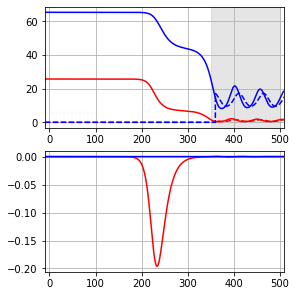

In [14]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-12
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,-int_t_pen:] = target[0]
    target_[:,1,-int_t_pen:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,-int_t_pen:] = target[0]
        target_[:,1,-int_t_pen:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)